<a href="https://colab.research.google.com/github/ceos-seo/odc-colab/blob/master/notebooks/02.01.Colab_Cloud_Statistics_L8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Landsat-8 Cloud Statistics

This notebook uses global Landsat-8 data from Google Earth Engine which has been indexed to work with the Open Data Cube. The selected data is used to calculate cloud statistics for selected regions. This is valuable information for performing analysis. For example, if there are extensive clouds for a season it may significantly impact the mosaic product or index values. Another example is that a user may want to find a single date when there are few clouds to assess land features.

This baseline notebook runs in about 5 minutes after the Google authorization step is complete. The default region (0.15 degrees square) and time window (9 months) uses about 1 GB of the allocated 12 GB of RAM and about 38 GB of the 100 GB of storage. Selecting larger regions and time windows should be done carefully to avoid exceeding the system limits or having long run times.

## Instructions for Execution
It is suggested that users first execute the notebook "as is" to successfully complete the Google authorizations and view sample results. Then, users should look for the "MODIFY HERE" labels at the top of several code blocks to identify code that can be modified. These include:<br>
<br>#1 - Define the center and size of the analysis region
<br>#2 - Select a time range for the data analysis
<br>#3 - Select a time slice from the coverage summary table to view 
<br><br>
Once the full notebook has been run, users can run individual code blocks using "Shift-Return" or run segments of the code using the Runtime menu. Users do not have to go thru the Google authorization steps for additional execution cycles. 

In [1]:
!wget -nc https://raw.githubusercontent.com/ceos-seo/odc-colab/master/odc_colab.py
from odc_colab import odc_colab_init
odc_colab_init(install_odc_gee=True)

In [2]:
from odc_colab import populate_db
populate_db()

In [3]:
# Suppress Warning Messages
import warnings
warnings.filterwarnings('ignore')

# Load Data Cube Configuration
from odc_gee import earthengine
dc = earthengine.Datacube(app='Cloud_Statistics')

# Import Data Cube API
import utils.data_cube_utilities.data_access_api as dc_api  
api = dc_api.DataAccessApi()

# Import Data Cube Utilities
import datacube
from utils.data_cube_utilities.clean_mask import landsat_clean_mask_invalid, landsat_qa_clean_mask
from utils.data_cube_utilities.dc_display_map import display_map
from utils.data_cube_utilities.dc_rgb import rgb

# Import Common Utilities
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd

In [4]:
# Define the Product and Platform
# This data is indexed from Google Earth Engine data sources

product = "ls8_google"
platform = "LANDSAT_8"

In [5]:
#1 MODIFY HERE

# Select a Latitude-Longitude point for the center of the analysis region
# Select the size of the box (in degrees) surrounding the center point

# Mombasa, Kenya
lat_long = (-4.03, 39.62)
box_size_deg = 0.15

# Calculates the latitude and longitude bounds of the analysis box
latitude = (lat_long[0]-box_size_deg/2, lat_long[0]+box_size_deg/2)
longitude = (lat_long[1]-box_size_deg/2, lat_long[1]+box_size_deg/2)

In [6]:
#2 MODIFY HERE

# Select a time range
# The inputs require a format (Min,Max) using this date format (YYYY-MM-DD)
# The Landsat-8 allowable time range is: 2013-04-07 to current
time_extents = ('2021-01-01', '2021-04-01')

In [7]:
# The code below renders a map that can be used to view the region.
# It is possible to find new regions using the map below. 
# Use your mouse to zoom in/out to explore new regions
# Click on the map to view Lat-Lon coordinates of any location that could define the region boundary

display_map(latitude,longitude)

## Calculate cloud coverage percentage for each pixel 

In [8]:
# Create a custom cloud coverage table here

def build_cloud_coverage_table_landsat(product,platform,collection,level,
                                       latitude,longitude,time=None,dc=None,
                                       extra_band='green',extra_load_params={}):
    
    dc = dc if dc is not None else datacube.Datacube(app="")

    load_params = dict(product=product,
                       latitude=latitude,
                       longitude=longitude,
                       measurements=[extra_band, 'pixel_qa'],
                       **extra_load_params)

    if time is not None:
        load_params["time"] = time

    landsat_dataset = dc.load(**load_params).persist()
    
    dates = [dt.astype('datetime64[D]') for dt in landsat_dataset.time.values]
        
    clean_masks = landsat_qa_clean_mask(landsat_dataset, platform=platform,
                                        collection=collection, level=level) & \
                  landsat_clean_mask_invalid(landsat_dataset, platform, collection, level)
    clean_percent = [clean_mask.mean()*100 for clean_mask in clean_masks.values]
    clean_count = list(map(np.sum, clean_masks.values))
    
    nodata_masks = xr.full_like(clean_masks, False)
    band_nodata_values = dc.list_measurements().loc[product, 'nodata']
    if band_nodata_values is not None:
        for data_var in landsat_dataset.values():
            band_nodata_masks = data_var == data_var.attrs['nodata']
            nodata_masks = nodata_masks | band_nodata_masks
    nodata_percent = [nodata_mask.mean()*100 for nodata_mask in nodata_masks.values]
    
    cloud_masks = (~clean_masks & ~nodata_masks)
    cloud_percent = [cloud_mask.mean()*100 for cloud_mask in cloud_masks.values]
            
    total_count = list(map(np.sum, ~nodata_masks.values))

    data = {"Date": dates,"Clean_percent": clean_percent,"Cloud_percent": cloud_percent,
            "NoData_percent": nodata_percent,"Clean_count": clean_count,"Total_count": total_count}

    return (landsat_dataset,
            pd.DataFrame(data=data, columns=list(data.keys())),
            cloud_masks, nodata_masks, clean_masks)

In [9]:
# Load the metadata for the given region and time period
landsat_dataset, coverage_table = build_cloud_coverage_table_landsat(dc=dc,
                                                                     product=product,
                                                                     platform=platform,
                                                                     collection='c2',
                                                                     level='l2',
                                                                     latitude=latitude,
                                                                     longitude=longitude,
                                                                     time=time_extents,
                                                                     extra_band='green')[0:2]

## Create a table of cloud coverage percentage for each date
This table displays data for each time slice in the cube (starting at an index=0). The "clean percent" is the percent of pixels WITHOUT clouds. So, low numbers are cloudy scenes and high numbers are clearer scenes. The "Clean_count" is the number of clear pixels in the scene and the "Total_count" is the total number of pixels in the scene.

Typically, there is a separation of 16 days between Landsat-8 views for a single location. When there is significant cloud cover, scenes may be missing from time series due to issues with processing and geolocation.

In [10]:
pd.set_option('display.max_rows', len(coverage_table))
coverage_table

,Date,Clean_percent,Cloud_percent,NoData_percent,Clean_count,Total_count
0,2021-01-07,21.137623,78.862377,0.0,65697,310806
1,2021-01-23,2.249957,97.750043,0.0,6993,310806
2,2021-02-24,22.152725,77.847275,0.0,68852,310806
3,2021-03-12,31.713995,68.286005,0.0,98569,310806
4,2021-03-28,99.994530,0.005470,0.0,310789,310806


## Create a plot of cloud coverage percentage for each date
The y-axis is the "clean percentage" from the table above.

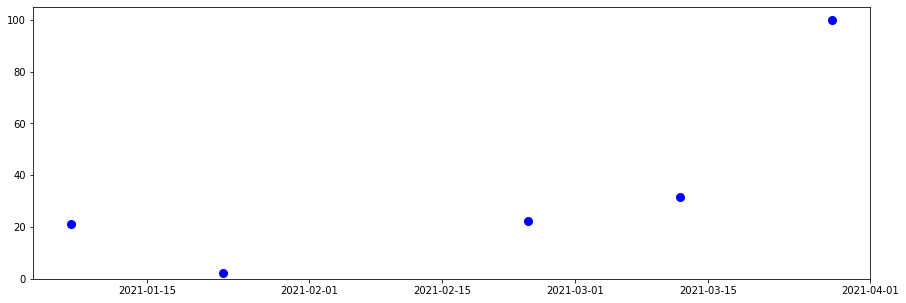

In [11]:
plt.figure(figsize = (15,5))
plt.plot(coverage_table["Date"].values, coverage_table["Clean_percent"].values, 'bo', markersize=8)
plt.ylim([0, 105])
plt.show()

## Review an RGB scene for a selected time slice

In [12]:
# Load the data to create an RGB image
landsat_dataset = dc.load(latitude=latitude,longitude=longitude,platform=platform,time=time_extents,
                          product=product,measurements=['red', 'green', 'blue', 'nir', 'swir1', 'swir2']) 

In [13]:
#3 MODIFY HERE

# Select one of the time slices and create an output image. 

# Time slices are numbered from 0 to x and shown in the summary table above
# Review the clean_percentage values to select scenes with few clouds
# Clouds will be visible in WHITE for an output image

slice = 4

In [14]:
# Collection 2 needs scale and offset applied for better color rendering
scale = lambda da: (da*da.attrs.get('scale_factor', 1))+da.attrs.get('add_offset', 0)

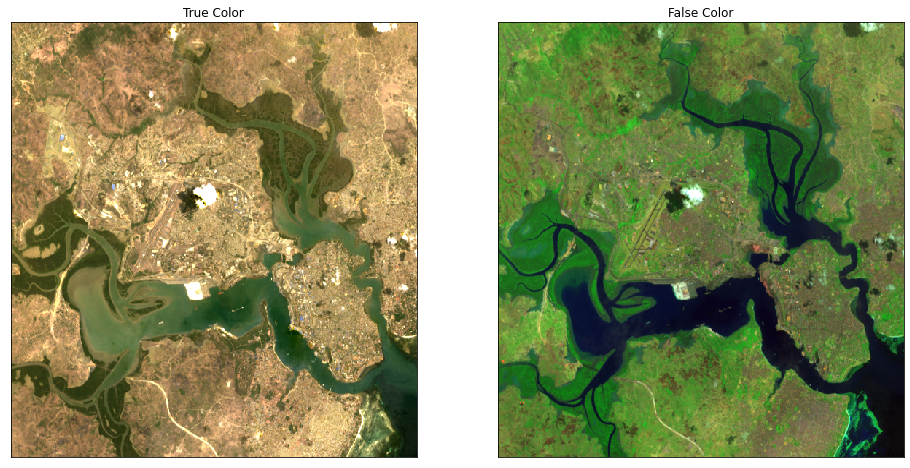

In [18]:
# Define the RGB image parameters
# True-Color = red, green, blue (this is the common true-color RGB image)
# False Color = swir2, nir, green (this is commonly used for Landsat data viewing)

true_rgb = landsat_dataset.isel(time=slice)[['red', 'green', 'blue']].map(scale).to_array()
false_rgb = landsat_dataset.isel(time=slice)[['swir2', 'nir', 'green']].map(scale).to_array()

# Define the plot settings and show the plots
# Users may want to alter the figure sizes or plot titles
# The "vmax" value controls the brightness of the images and can be adjusted 

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
true_rgb.plot.imshow(ax=ax[0], vmin=0, vmax=0.2)
false_rgb.plot.imshow(ax=ax[1], vmin=0, vmax=0.5)
ax[0].set_title('True Color'), ax[0].xaxis.set_visible(False), ax[0].yaxis.set_visible(False)
ax[1].set_title('False Color'), ax[1].xaxis.set_visible(False), ax[1].yaxis.set_visible(False)
plt.show()